# Overview

In this project, we will perform image segmentation task using the [Oxford III-T Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). We will not worry about the specific pet categories for now. The goal is to create an algorithm that can segment and predict the `foreground` (pet) and `background`.

# Import modules

In [1]:
import os, glob
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from natsort import natsorted
from clearml import Logger, Task
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from simple_parsing import ArgumentParser
from torch.utils.data import Subset, Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from simple_parsing import ArgumentParser
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor


random.seed(42)
torch.manual_seed(42)

# Define hyperparameters

In [2]:
from dataclasses import dataclass

@dataclass
class Args:
    """
    Training arguments.
    """

    # Learning rate for the optimizer
    learning_rate: float = 1e-3
    # Training batch size
    batch_size: int = 16
    # Total numebr of classes
    num_classes: int = 2
    # Maximum number of training epochs
    epochs: int = 10
    
args = Args()

# Data Preprocessing

Downloaded the dataset and removed unnecessary files. Just keeping the `images` and the `masks`.

In [3]:
# Define paths

DATA_ROOT = "./data"
images_dir = os.path.join(DATA_ROOT, "images")
masks_dir = os.path.join(DATA_ROOT, "masks")

## Check images and masks

The total number of `images` and `masks` should be same.

In [4]:
# Check total number of images and masks

images_list = natsorted(os.listdir(images_dir))
masks_list = natsorted(os.listdir(masks_dir))
print(f"Total images: {len(images_list)}")
print(f"Total masks: {len(masks_list)}")

Total images: 7393
Total masks: 7390


The total number of images and mask is not same. Either we have missing masks or we have some files whic hare not images.

In [5]:
# Function to check corrupted images

def test_files(images_list: list, images_dir: str):
    corrupted = []
    for filepath in images_list:
        full_path = os.path.join(images_dir, filepath)
        filename = full_path.split("/")[-1]
        if filename.endswith((".jpg", ".png")): # requires tuple
            try:
                img = Image.open(full_path) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print("Bad file: ", filename) # print out the names of corrupt files
                corrupted.append(filename)
        else:
            print("Not an image: ", filename) # find the files that are not images
            corrupted.append(filename)
        
    return corrupted

In [6]:
# Check for corrupted images and masks
corrutped_images = test_files(images_list, images_dir)

Not an image:  Abyssinian_100.mat
Not an image:  Abyssinian_101.mat
Not an image:  Abyssinian_102.mat


In [7]:
corrutped_masks = test_files(masks_list, masks_dir)

We can create a new list which contains only the valid paths that exist in both lists.

In [8]:
# Create list of vlaid images and masks

valid_paths = [img_path for img_path in images_list if img_path.endswith(".jpg") and os.path.exists(os.path.join(images_dir, img_path)) and img_path[:-3] + "png" in masks_list]
valid_mask_paths = [img_path[:-3] + "png" for img_path in valid_paths]

In [9]:
print(f"Total valid images: {len(valid_paths)}")
print(f"Total valid masks: {len(valid_mask_paths)}")

Total valid images: 7390
Total valid masks: 7390


# Split the dataset

We will be using custom split instead of the original split. We will allocate more data to `train` and `valid` set and assing few images to `test` set.

In [10]:
# Split the data into training and test set
trainval_imgs, test_imgs, trainval_masks, test_masks = train_test_split(valid_paths, valid_mask_paths, test_size=0.01, random_state=42)

In [11]:
# Split the data into training and validation sets
train_imgs, val_imgs, train_masks, val_masks = train_test_split(valid_paths, valid_mask_paths, test_size=0.10, random_state=42)

In [12]:
# Check the number of images and masks in each set
print(f"Number of training images: {len(train_imgs)}")
print(f"Number of validation images: {len(val_imgs)}")
print(f"Number of test images: {len(test_imgs)}")

Number of training images: 6651
Number of validation images: 739
Number of test images: 74


## Visualize data

Lets visualize some of the images along with their masks. We will also add an option to display the predicted mask which we will use later. Also we convert all the masks to only two categories i.e. 0 for the background and 1 for the pet.

In [13]:
# Functions to process masks
def process_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0 # set all background labels to 0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0 # set all pet labels to 1
    return mask

In [14]:
def display_images(images_list, images_dir, masks_list, masks_dir, masks_predicted=None):
    images_list = images_list[:10] # just plot 10 images
    num_cols = 3 if masks_predicted else 2
    num_rows = len(images_list)
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 20))
    for idx, (image_name, mask_name) in enumerate(zip(images_list, masks_list)):
        # read and process
        image = cv2.imread(os.path.join(images_dir, image_name)) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(masks_dir, mask_name), cv2.IMREAD_UNCHANGED)
        mask = process_mask(mask)
        
        # display images and masks
        ax[idx, 0].imshow(image)
        ax[idx, 1].imshow(mask, interpolation="nearest")
        ax[idx, 0].set_title("Image")
        ax[idx, 1].set_title("Mask")
        ax[idx, 0].set_axis_off()
        ax[idx, 1].set_axis_off()
        
        if masks_predicted:
            predicted_mask = masks_predicted[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()        

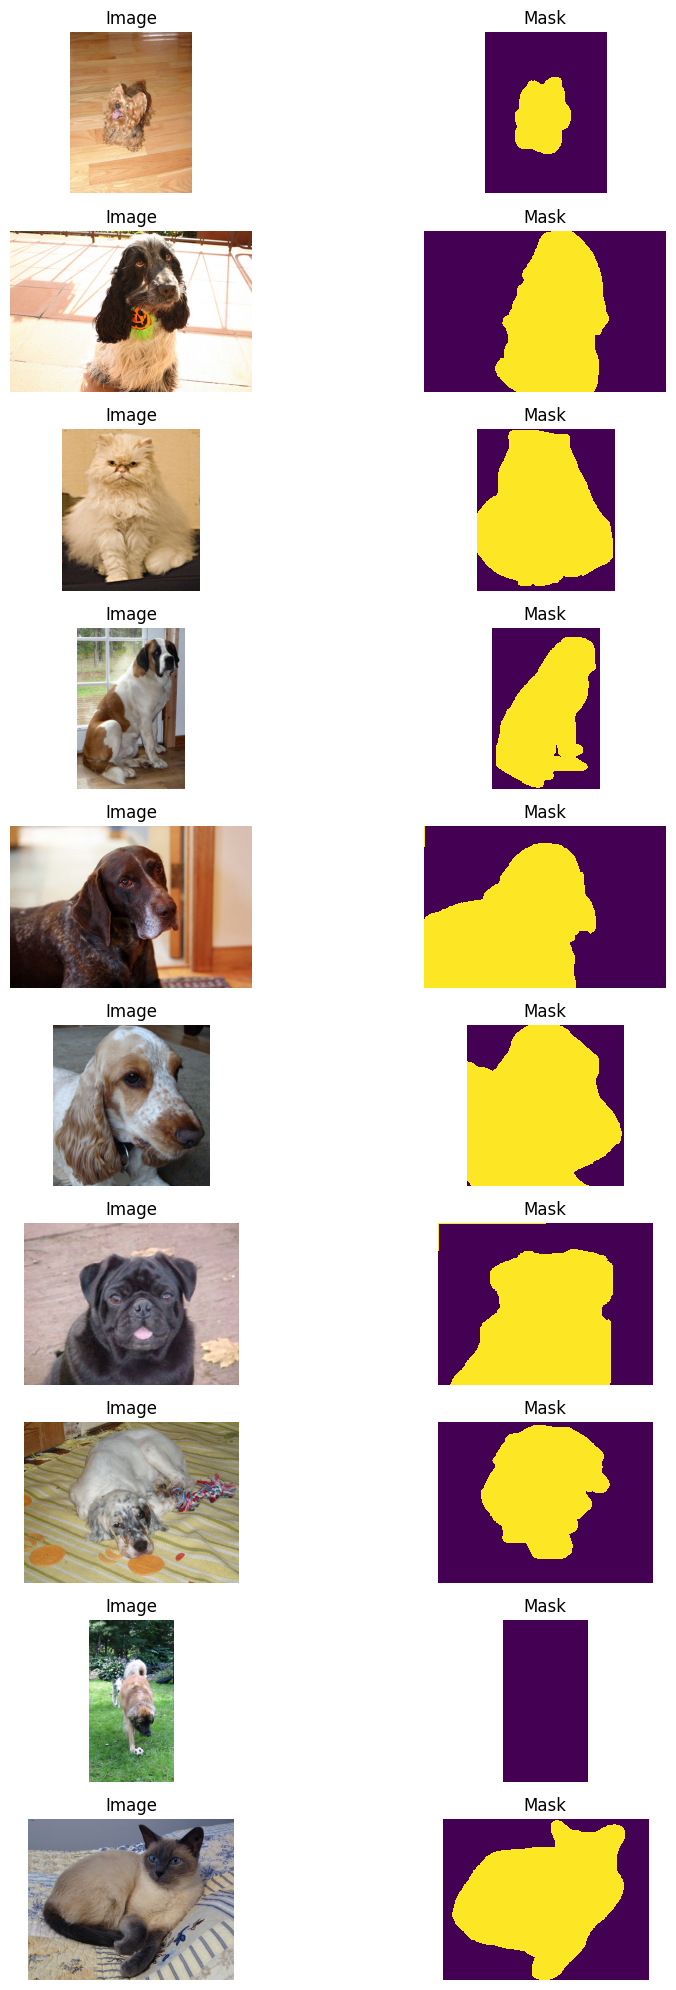

In [15]:
display_images(val_imgs, images_dir, val_masks, masks_dir)

# Define the model

Next we define out model class. We will be using [SegFormer](https://arxiv.org/abs/2105.15203#) model mainly because of its small size, good accuracy and efficient architecture.

# Loading data

Next we define our `dataset` class and  `dataloaders` that we will be using to train out model.

## Creating Pytorch dataset
We will define a dataset class that will load the images and masks from the directory. It will also contain `transform` parameter to apply some transformations to the data. We wil lalso use image processor to process image for the segformer model.

In [34]:
class PetDataset(Dataset):
    def __init__(self, images_list, images_dir, masks_list, feature_extractor, transform=None):
        self.image_files = images_list
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.feature_extractor = feature_extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image = cv2.imread(os.path.join(self.images_dir, image_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_dir, image_file.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = process_mask(mask)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            encoded_inputs = self.feature_extractor(transformed["image"], transformed["mask"], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Now we can define some `transformations` and `augmentations` to apply to our dataset for better generalization performance. We will use `albumentations` for that.

In [35]:
# Define transform function

def get_transform(dataset):

    resize = A.Resize(224, 224)
    normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    bright_contrast = A.RandomBrightnessContrast(
        brightness_limit=0.3, contrast_limit=0.3, p=0.3
    )
    rgb_shift = A.RGBShift(p=0.2)
    jitter = A.ColorJitter(p=0.3)
    hor_flip = A.HorizontalFlip(p=0.2)
    shift_scale_rotate = A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.3)
    to_tensor = ToTensorV2()

    if dataset == "train":
        return A.Compose([resize, bright_contrast, hor_flip, rgb_shift, jitter, shift_scale_rotate, normalize, to_tensor])
    elif dataset == "val":
        return A.Compose([resize, normalize, to_tensor])

In [36]:
feature_extractor = SegformerImageProcessor(do_resize=False, do_rescale=False, do_normalize=False)

train_dataset = PetDataset(train_imgs, images_dir, masks_dir, feature_extractor, transform=get_transform("train"))
val_dataset = PetDataset(val_imgs, images_dir, masks_dir, feature_extractor, transform=get_transform("val"))

In [37]:
print(len(train_dataset), len(val_dataset))

6651 739


In [38]:
encoded_inputs = train_dataset[0]
encoded_inputs["pixel_values"].shape

torch.Size([3, 224, 224])

Initially I will overfit on a tiny dataset to see if everything is working correctly. For that purpose we can create `subsets` of teh data.

In [21]:
# Sanity check subset function

def create_subset(trainset, valset):

    train_subset = Subset(trainset, range(50))
    val_subset = Subset(valset, range(10))

    return train_subset, val_subset

train_subset, val_subset = create_subset(train_dataset, val_dataset)
print(len(train_subset), len(val_subset))

50 10


## Dataloaders

In [22]:
# Create dataloaders

train_dataloader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=args.batch_size, shuffle=False)

In [27]:
# Test dataloaders

# Get first batch of images and masks
images, masks = next(iter(train_dataloader))

print(masks)

# Convert the tensors to numpy arrays
# images = images.numpy()
# masks = masks.numpy()

# print(images.shape)

# # # Get the number of images in the batch
# num_images = images.shape[0]

# # # Plot some examples
# fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 30))

# for i in range(num_images):
#     # Rescale the pixel values to the valid range of [0, 1]
#     img_rescaled = (images[i] + 1) / 2
#     axes[i][0].imshow((img_rescaled*255).transpose(1, 2, 0).astype(np.uint8))
#     axes[i, 0].set_title("Image")
#     axes[i][0].axis('off')
#     axes[i][1].imshow(masks[i])
#     axes[i, 1].set_title("Mask")
#     axes[i][1].axis('off')
# plt.tight_layout()
# plt.show()

labels


# Defining model